In [1]:
from processed_image import ProcessedImage, read_from_dir, show_image_strip
imgs = list(read_from_dir('..\\Data\\LittleCarDb1'))
[str(img) for img in imgs[0:5]]

['ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-001_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-002_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-005_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-007_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-008_1.jpg (0 in cache)']

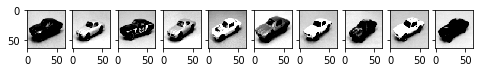

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 10, sharey=True, figsize=(8,1.5))
show_image_strip(imgs, axes)

In [ ]:
_, axes = plt.subplots(2, 10, sharey=True, figsize=(8,1.5))
processed_dict = {img.fullpath:img.get_processed_image() for img in imgs}
show_image_strip(imgs, axes, predicted_dict=processed_dict)

In [ ]:
import numpy as np
x_train = [img.get_processed_image() for img in imgs]
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [ ]:
from keras.losses import mse, binary_crossentropy
from keras import backend as K

from model_vae_3stage import build_encoded_layer, build_latent_encoder, build_decoder, build_autoencoder

def build_my_autoencoder(sz, optimizer, loss, latent_dim=8):
    encoded_layer, input_img = build_encoded_layer(sz, in_channels=1)  
    
    encoded_shape = K.int_shape(encoded_layer)
    encoder, z_mean, z_log_var = build_latent_encoder(encoded_layer, input_img, latent_dim=latent_dim)
    
    decoder = build_decoder(sz, encoded_shape, in_channels=1, latent_dim=latent_dim)
    autoencoder = build_autoencoder(encoder, decoder, input_img,
                                    optimizer=optimizer, loss=loss, dump=True)
    return autoencoder, encoder, decoder

In [ ]:
optimizer = 'adadelta'
loss = ['mean_squared_error', 'categorical_crossentropy', 'binary_crossentropy']
vae, enc, dec = build_my_autoencoder(64, optimizer=optimizer, loss=loss[0], latent_dim=8)

In [4]:
from model_vae_3stage import ModelVae3Stage
all_model = ModelVae3Stage(size=64, in_channels=1, latent_dim=8)
vae, enc, dec = all_model.vae, all_model.encoder, all_model.decoder

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


TypeError: build_autoencoder() missing 1 required positional argument: 'input_img'

In [ ]:
import random
x_test = np.array(random.sample(list(x_train), int(len(x_train)/10)))
x_train.shape, x_test.shape

In [ ]:
vae.fit(x_train, x_train, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[i].reshape(64, 64), cmap='gray')
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded[i].reshape(64, 64), cmap='gray')
    plt.show()
show_original_decoded(x_test, decoded_imgs, 128)